In [1]:
from vtl.Readfile import Readfile
from vtl.Photo import Photometry
from spec_id import Analyze_LH_lwa, Error,Oldest_galaxy, Gen_spec, Stack,Median_model, \
    Median_w_Error,Median_w_Error_cont,Likelihood_contours,Gen_sim, Stack_posteriors, Linear_fit , \
    Median_w_Error_95,Gen_grid,Iterative_stacking
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
pandas2ri.activate()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_3.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

def Gen_grid_dust(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_dust.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [32]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')
lwa_grid = np.load('../data/light_weight_scaling_3.npy')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [105]:
"""DATA"""
PZl_grid = Gen_grid(mzDB,'Z')
PTl_grid = Gen_grid(mzDB,'t')

PZl,PZx = Iterative_stacking(PZl_grid,metal)
PTl,Ptx = Iterative_stacking(PTl_grid,age)

Zmedl, Zler, Zher = np.round(Median_w_Error_95(PZl,PZx),3)
tmedl, tler, ther = np.round(Median_w_Error_95(PTl,Ptx),1)

zstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
zstack.Stack_normwmean()
zstack.Stack_normwmean_model(Zmedl,3.4,tau,bftau=8.6)
stack = zstack.mfl

../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../dat

In [102]:
print Zmedl
print Zmedl - Zler
print Zmedl + Zher

print tmedl
print tmedl - tler
print tmedl + ther


print lwa_grid[np.argwhere(np.round(metal,3) == 0.019)[0][0]][np.argwhere(np.round(age,1) == 3.4)[0][0]][np.argwhere(np.round(tau,1) == 8.6)[0][0]]


0.019
0.01
0.027
2.5
1.4
3.8
2.52797779199


In [113]:
chi = []
good_age =[]
good_tau =[]
for i in range(len(tau)):
    for ii in range(age.size):
        lwa = lwa_grid[np.argwhere(np.round(metal,3) == 0.019)[0][0]][ii][i]
        if lwa > (tmedl + ther - 0.05) :
            zstack.Stack_normwmean_model(Zmedl,age[ii],tau,bftau=tau[i])
            chi.append(sum(((zstack.fl - zstack.mfl) / zstack.er)**2))
            good_age.append(age[ii])
            good_tau.append(tau[i])
            break

../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../dat

[ 6.]
[ 8.85]
679.998144694
163.219552622


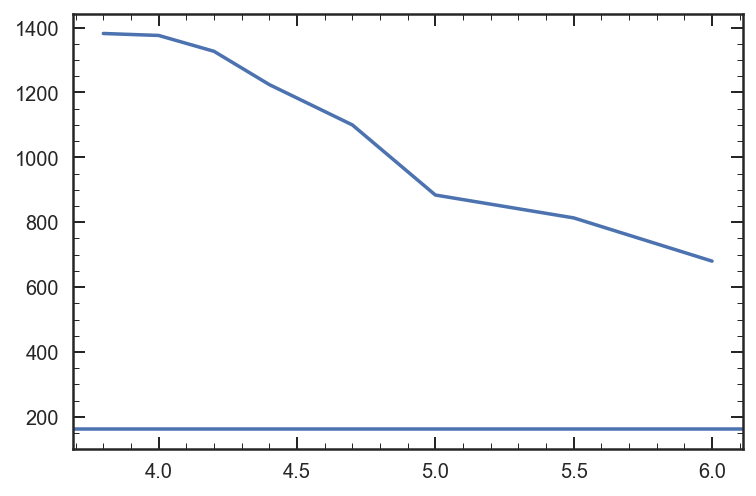

In [114]:
plt.plot(good_age,chi)
plt.axhline(163)

print np.array(good_age)[chi == min(chi)]
print np.array(good_tau)[chi == min(chi)]
print min(chi)
print 2*np.sqrt(2*len(stack)) + 126.45

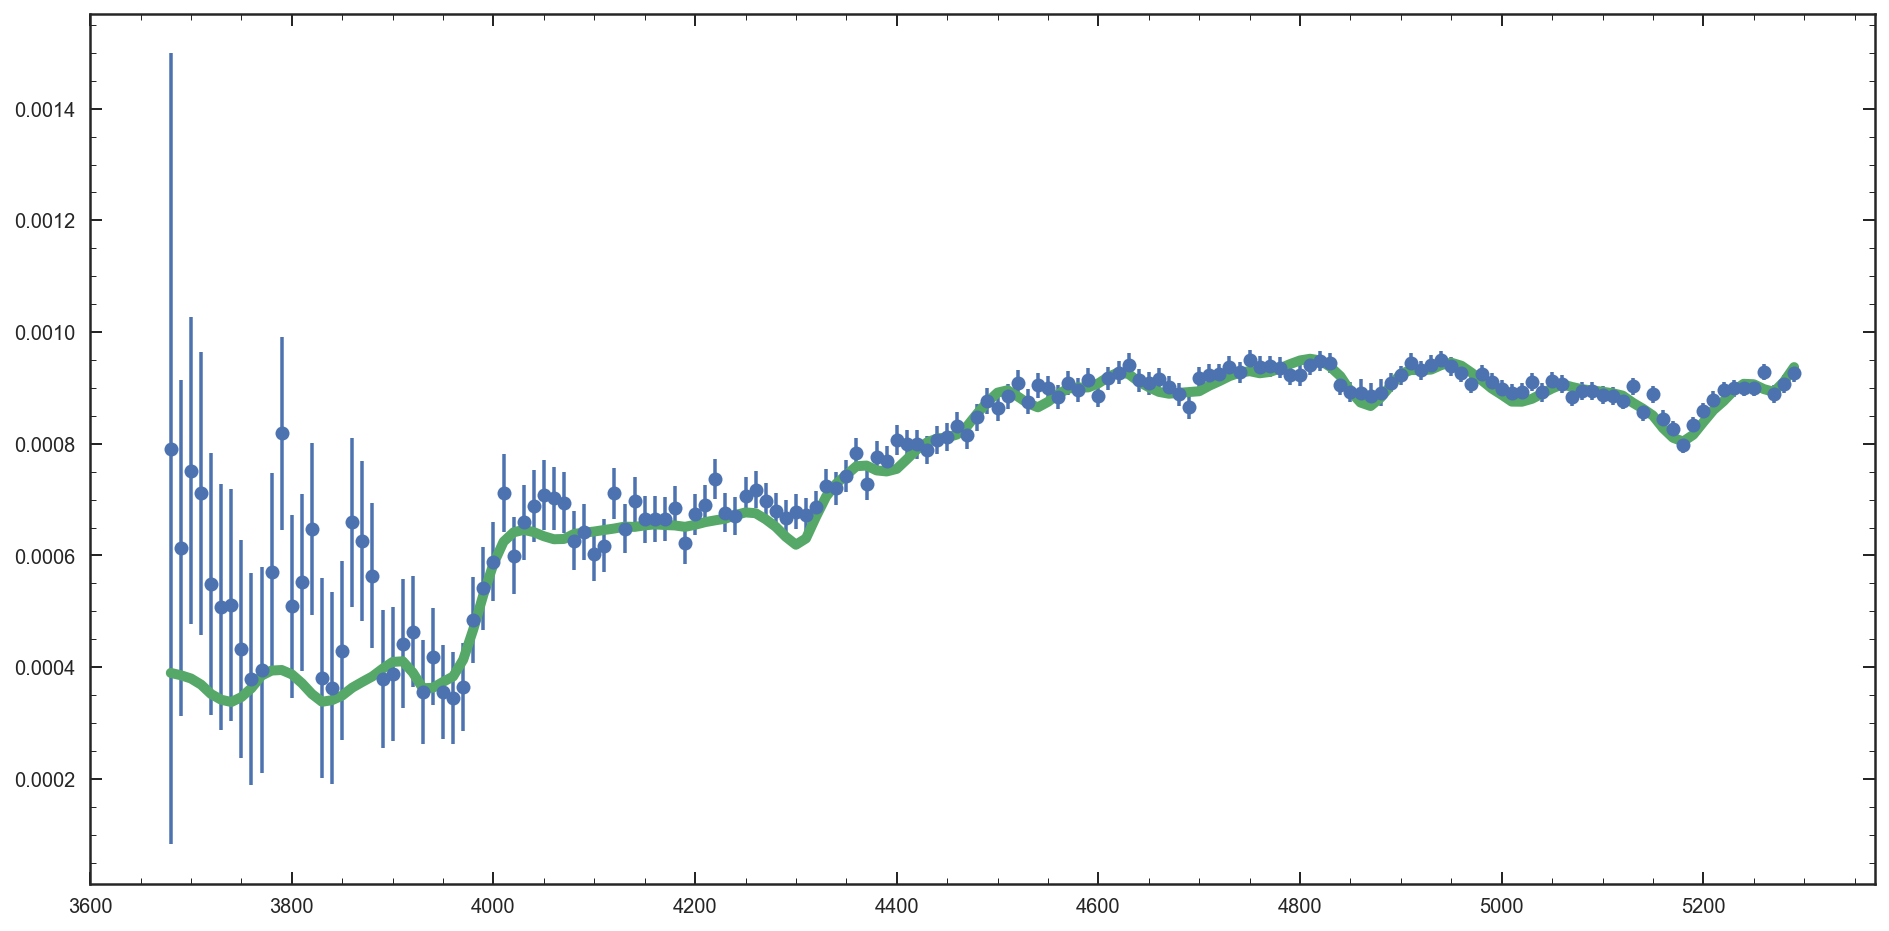

In [79]:
plt.figure(figsize=[16,8])
plt.errorbar(zstack.wv,zstack.fl,zstack.er,fmt='o')
plt.plot(zstack.wv,stack,linewidth=5)

In [90]:
zstack.Stack_normwmean_model(0.02,2.3,tau,bftau=0)
zlstack = zstack.mfl   
zstack.Stack_normwmean_model(0.02,5.2,tau,bftau=0)
zhstack = zstack.mfl    

zstack.Stack_normwmean_model(0.01,3.8,tau,bftau=0)
tlstack = zstack.mfl   
zstack.Stack_normwmean_model(0.028,3.8,tau,bftau=0)
thstack = zstack.mfl 

../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat
../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../dat

In [87]:
"""PLOT"""

def Plot_stack(wv, fl, er, mfl1, mfl2, mfl3, mfl4, mfl5
               ,bfm,bfml,bfmh,bfa,bfal,bfah,window=[],save_plot=False,plot_name=''):
    
    gs = gridspec.GridSpec(2,1,hspace=0)
    
    plt.figure(figsize=[12,14])
    plt.subplot(gs[0])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#404040',fmt='o',ms = 4,elinewidth=2)
    plt.plot(wv,mfl1 * 1000,color='#ca0020',
             label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.plot(wv,mfl2 * 1000,color='#f4a582',zorder = 5,linewidth = 2,
            label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfml/0.019,2),bfa) )
    plt.plot(wv,mfl3 * 1000,color='k',zorder = 5,linewidth = 2,
            label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfmh/0.019,2),bfa))
    
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.05,'Ca HK',fontsize=15)
    plt.text(4080,window[3]+.05,'H$\delta$',fontsize=15)
    plt.text(4280,window[3]+.05,'G+H$\gamma$',fontsize=15)
    plt.text(4830,window[3]+.05,'H$\\beta$',fontsize=15)
    plt.text(5160,window[3]+.05,'Mgb',fontsize=15)
    plt.ylim(0.01,window[2])
    plt.xlim(window[0],window[1])
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
    
    plt.subplot(gs[1])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#404040',fmt='o',ms = 4,elinewidth=2)
    plt.plot(wv,mfl1 * 1000,color='#ca0020',
             label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.plot(wv,mfl4 * 1000,color='#f4a582',zorder = 5,linewidth = 2,
            label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfm/0.019,2),bfal))
    plt.plot(wv,mfl5 * 1000,color='k',zorder = 5,linewidth = 2,
            label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfm/0.019,2),bfah))
    
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.ylim(0.0,window[2])
    plt.xlim(window[0],window[1])
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
    
    if save_plot == True:
        plt.savefig(plot_name,bbox_inches = 'tight')
    else:
        plt.show()
    plt.close()

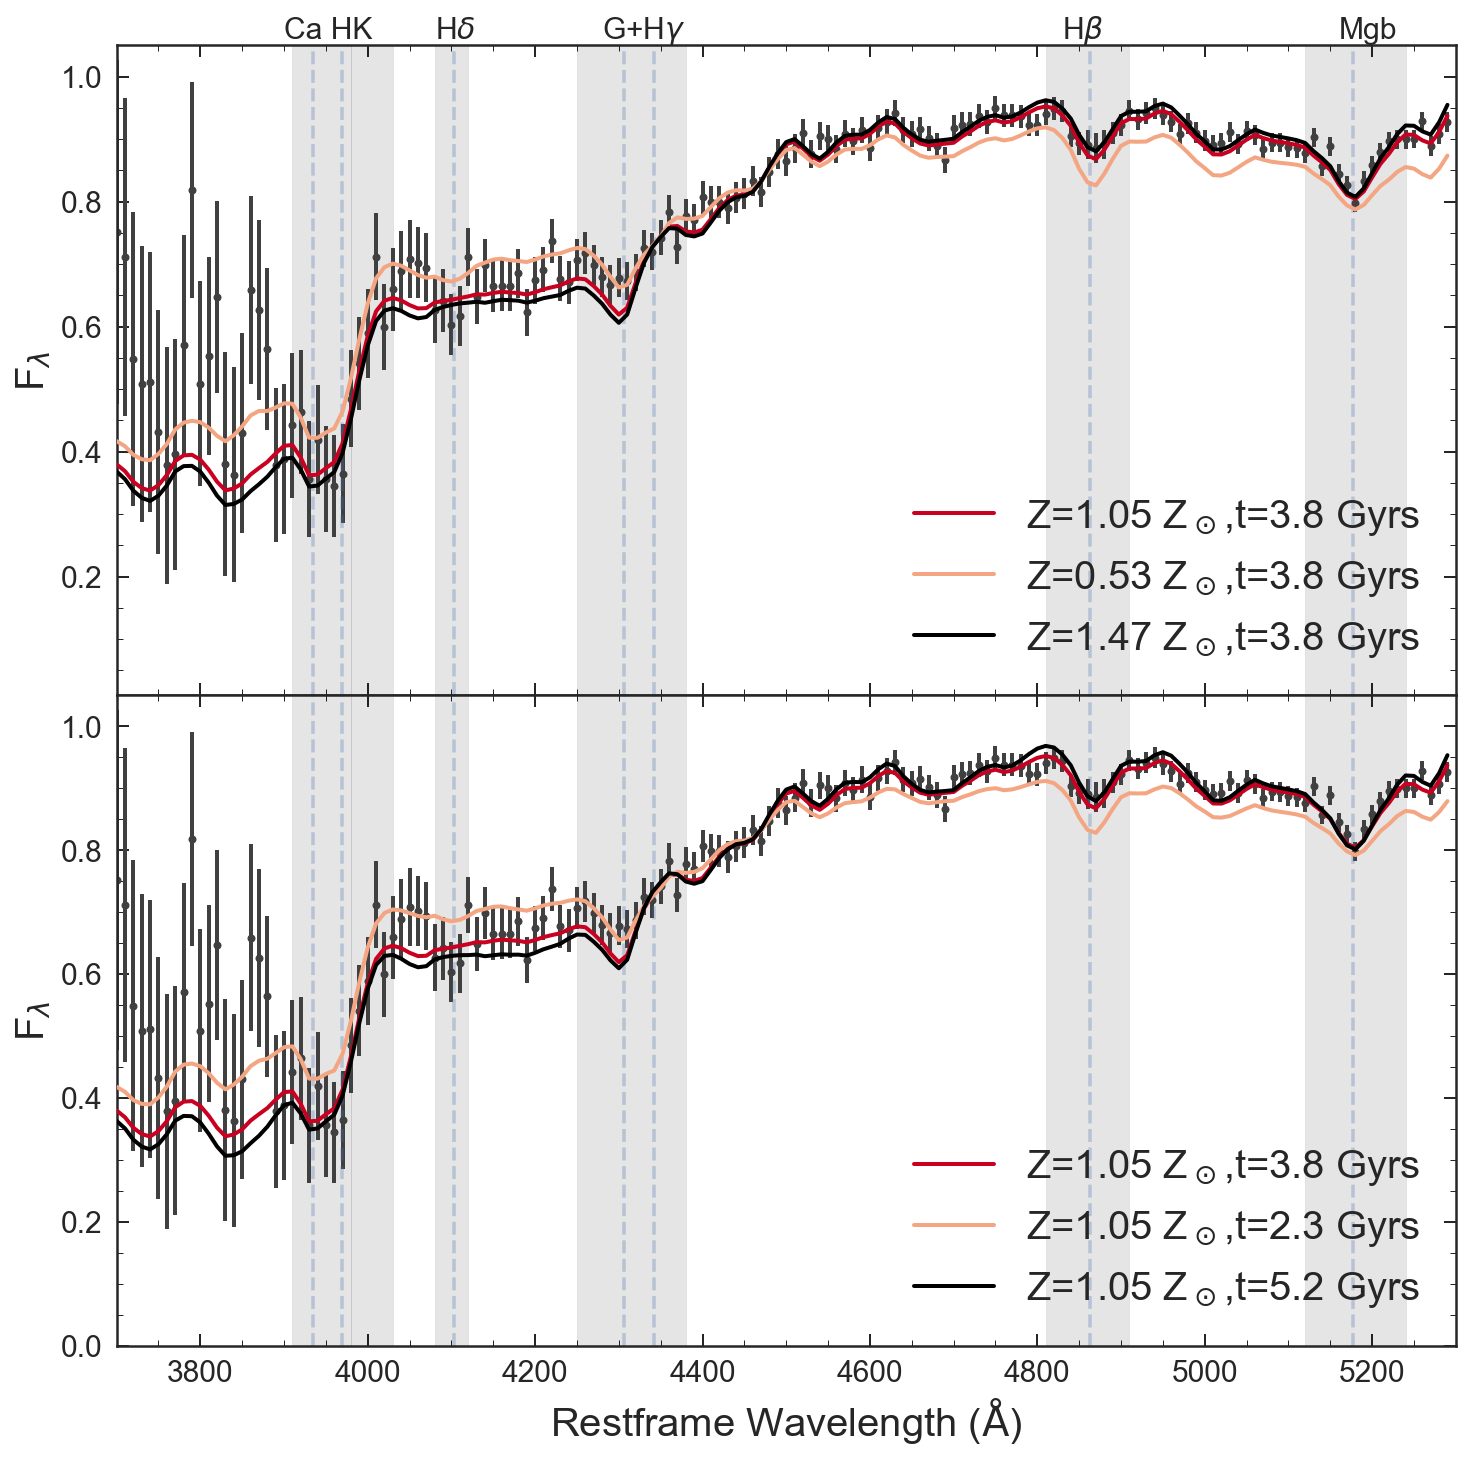

In [91]:
%matplotlib inline

Plot_stack(zstack.wv, zstack.fl, zstack.er, stack, zlstack, zhstack, tlstack, thstack, 
           Zmedl,Zmedl - Zler,Zmedl + Zher,tmedl,tmedl - tler,tmedl + ther,window=[3700,5300,1.05,1.01],save_plot=False,
           plot_name='../plots/stack_param_shift.pdf')

In [28]:
print Lzstack.fl.size
print np.sum(((Lzstack.fl - lstack)/ Lzstack.er)**2)
print np.sum(((Lzstack.fl - zlstack)/ Lzstack.er)**2)
print np.sum(((Lzstack.fl - zhstack)/ Lzstack.er)**2)

print np.sum(((Lzstack.fl - tlstack)/ Lzstack.er)**2)
print np.sum(((Lzstack.fl - thstack)/ Lzstack.er)**2)

162
132.532472999
651.956661459
152.031776996
474.918692228
160.109811508


In [12]:
m_pos=np.zeros([len(mzDB['gids'].values),age.size])
a_pos=np.zeros([len(mzDB['gids'].values),metal.size])

for i in range(len(mzDB.index)):
    P = np.load('../chidat/%s_dtau_tZ_pos_lwa_3.npy' % mzDB['gids'][mzDB.index[i]])
    m_pos[i] = P.T[17]/np.trapz(P.T[17],age)
    a_pos[i] = P[19]/np.trapz(P[19],metal)


In [10]:
age[19]

2.3999999999999995

In [22]:
P.T[0].shape

(56,)

In [31]:
Psum = np.zeros([age.size,metal.size])
for i in range(len(mzDB.index)):
    P = np.load('../chidat/%s_dtau_tZ_pos_lwa_3.npy' % mzDB['gids'][mzDB.index[i]])
    Psum += P

In [32]:
Pw = np.zeros(len(mzDB.index))
j=0
for i in range(len(mzDB.index)):
    Ps = np.zeros([age.size,metal.size])
    for ii in range(len(mzDB.index)):
        if i != ii:
            P = np.load('../chidat/%s_dtau_tZ_pos_lwa_3.npy' % mzDB['gids'][mzDB.index[ii]])
            Ps += P
            
    Pw[i] = 1 / np.sum((Ps - Psum)**2)

In [33]:
Pw

array([  1.43923388e-06,   9.64571418e-07,   1.06428919e-06,
         8.08626935e-07,   2.89885064e-06,   3.02078421e-06,
         1.39059705e-06,   1.07435510e-07])

In [34]:
Ssum = np.zeros([age.size,metal.size])
for i in range(len(mzDB.index)):
    P = np.load('../chidat/%s_dtau_tZ_pos_lwa_3.npy' % mzDB['gids'][mzDB.index[i]])
    Ssum += P * Pw[i]

In [38]:
metal.shape

(29,)

In [39]:
C = np.trapz(np.trapz(Ssum.T, age, axis=1), metal)
PS= Ssum / C

In [77]:
def Smooth_dist(y_o,x_o,resampling = 250):
    ksmooth = importr('KernSmooth')
    del_x = x_o[1] - x_o[0]

    ### resample
    x = np.linspace(x_o[0],x_o[-1],resampling)
    y = interp1d(x_o,y_o)(x)
   
    ### select bandwidth
    H = ksmooth.dpik(x)
    
    fx = ksmooth.locpoly(x,y,bandwidth = H)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    Fx = interp1d(X,iFX)(x)    
    Fx[Fx<0]=0
        
    return interp1d(x,Fx)(x_o)


In [64]:
interp1d

29
56


In [85]:
IPS = np.ones(PS.shape)
nPS = PS
for u in range(5):
    smPS = np.zeros(nPS.shape)
    IPS *= nPS
    for i in range(len(IPS)):
        smPS[i] = Smooth_dist(IPS[i],metal)

    C = np.trapz(np.trapz(smPS.T, age, axis=1), metal)
    IPS = smPS / C


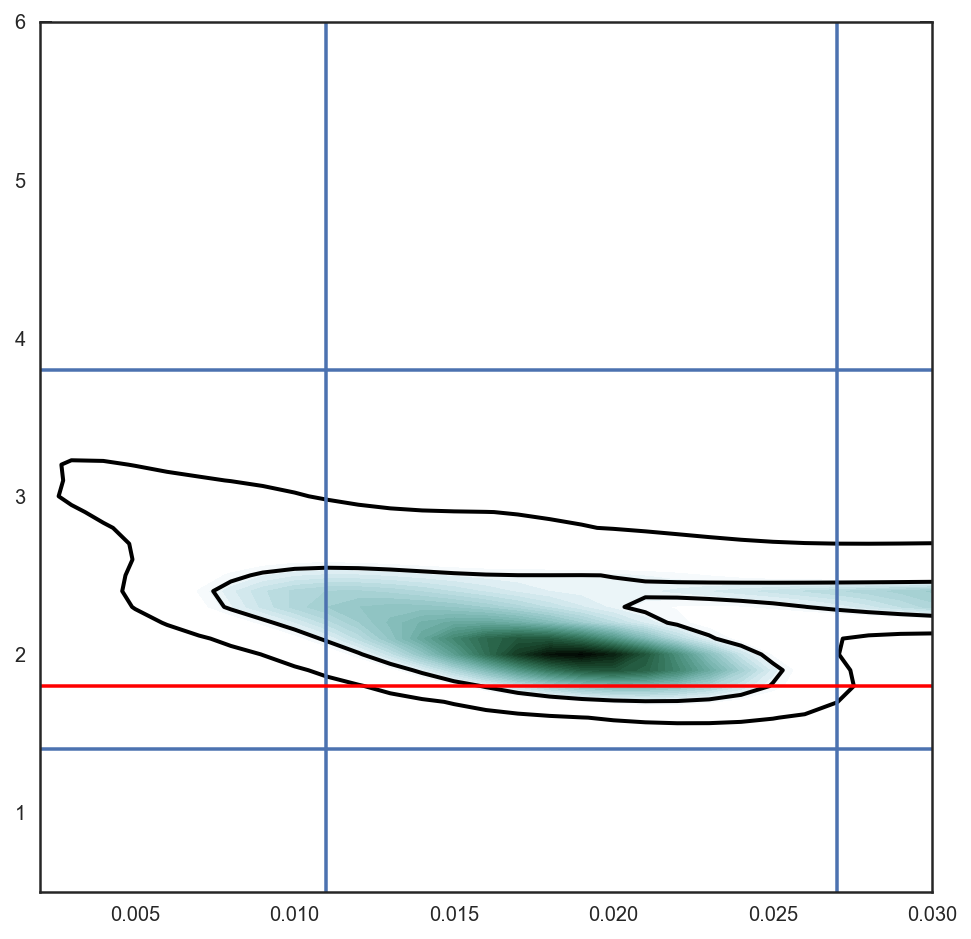

In [86]:
onesig,twosig = Likelihood_contours(age,metal,IPS)
levels = np.array([twosig,onesig])
plt.figure(figsize=[8,8])
plt.contour(M,A,IPS,levels,colors='k',linewidths=2)
plt.contourf(M,A,IPS,40,cmap=cmap)
plt.axvline(0.011)
plt.axvline(0.027)
plt.axhline(1.4)
plt.axhline(3.8)
plt.axhline(1.8,color='r')

In [24]:
P_e = np.ones([PZl.size,PTl.size])

In [25]:
for i in range(len(P_e)):
    P_e[i] *= PZl[i]
for i in range(len(P_e)):
    P_e.T[i] *= PTl[i]

In [30]:
C = np.trapz(np.trapz(P_e.T, Ptx, axis=1), PZx)
P_e = P_e / C

In [10]:
Ml,Al=np.meshgrid(PZx,Ptx)

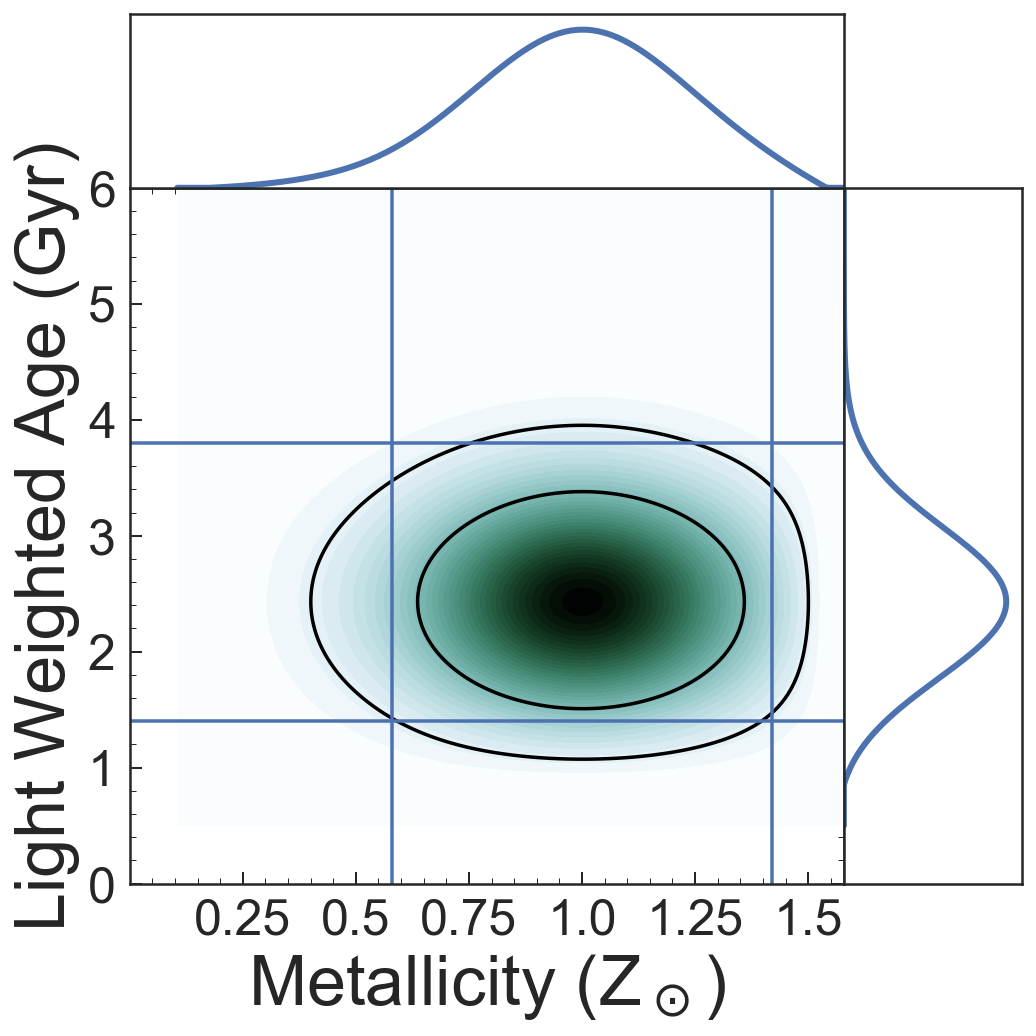

In [53]:
%matplotlib inline
onesig,twosig = Likelihood_contours(Ptx,PZx,P_e.T)
levels = np.array([twosig,onesig])

gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.contour(Ml,Al,P_e.T,levels,colors='k', linewidth=2)
plt.contourf(Ml,Al,P_e.T,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.axvline(0.011)
plt.axvline(0.027)
plt.axhline(1.4)
plt.axhline(3.8)
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyr)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])

plt.subplot(gs[0])
plt.plot(PZx,PZl,linewidth=3)
plt.xticks([])
plt.yticks([])
plt.xlim(0,0.03)
plt.ylim(0,max(PZl)*1.1)

plt.subplot(gs[3])
plt.plot(PTl,Ptx,linewidth=3)
plt.xticks([])
plt.yticks([])
plt.ylim(0,6)
plt.xlim(0,max(PTl)*1.1)
plt.show()

# Single Galaxy

In [8]:
###DATA
P = np.load('../chidat/n21156_dtau_tZ_pos_lwa_3.npy')
t,Pt = np.load('../chidat/n21156_dtau_t_pos_lwa_3.npy')
Z,PZ = np.load('../chidat/n21156_dtau_Z_pos_lwa_3.npy')
onesig,twosig = Likelihood_contours(age,metal,P)
levels = np.array([twosig,onesig])
spec = Gen_spec(galDB['gids'][61], galDB['hi_res_specz'][61])

No TEAL-based tasks available for this package!
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


In [121]:
print np.array(Median_w_Error_95(PZ,Z)) / .019
print Median_w_Error_95(Pt,t)

[ 1.0526316  0.42105263  0.42105263]
(2.2, 0.67500000000000000001, 0.802)


In [129]:
chi = []
good_age =[]
good_tau =[]
for i in range(len(tau)):
    for ii in range(age.size):
        lwa = lwa_grid[np.argwhere(np.round(metal,3) == 0.02)[0][0]][ii][i]
        if (2.2 + 0.802 - 0.1) < lwa < (2.2 + 0.802 + 0.1):
            spec.Sim_spec(0.02,age[ii],tau[i])
            chi.append(sum(((spec.gal_fl - spec.fl) / spec.gal_er)**2))
            good_age.append(age[ii])
            good_tau.append(tau[i])
#             break

In [38]:
print lwa_grid[np.argwhere(np.round(metal,3) == 0.02)[0][0]][26][0]


3.09


4.3 8.7
[ 5.]
[ 8.85]
209.814841785
256.413078365


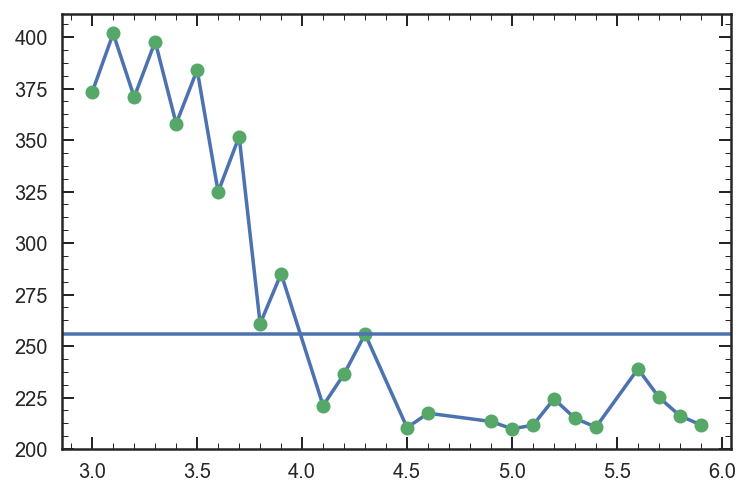

In [131]:
plt.plot(good_age,chi)
plt.plot(good_age,chi,'o')
plt.axhline(256)
# plt.ylim(0,300)

print good_age[12],good_tau[12]

print np.array(good_age)[chi == min(chi)]
print np.array(good_tau)[chi == min(chi)]
print min(chi)
print np.sqrt(2*len(spec.gal_wv))*2+ 209

In [132]:
print lwa_grid[np.argwhere(np.round(metal,3) == 0.02)[0][0]][np.argwhere(np.round(age,1) == 4.3)[0][0]][np.argwhere(np.round(tau,2) == 8.7)[0][0]]
# spec.Sim_spec(0.02,2.6,8.3)

3.09383413485


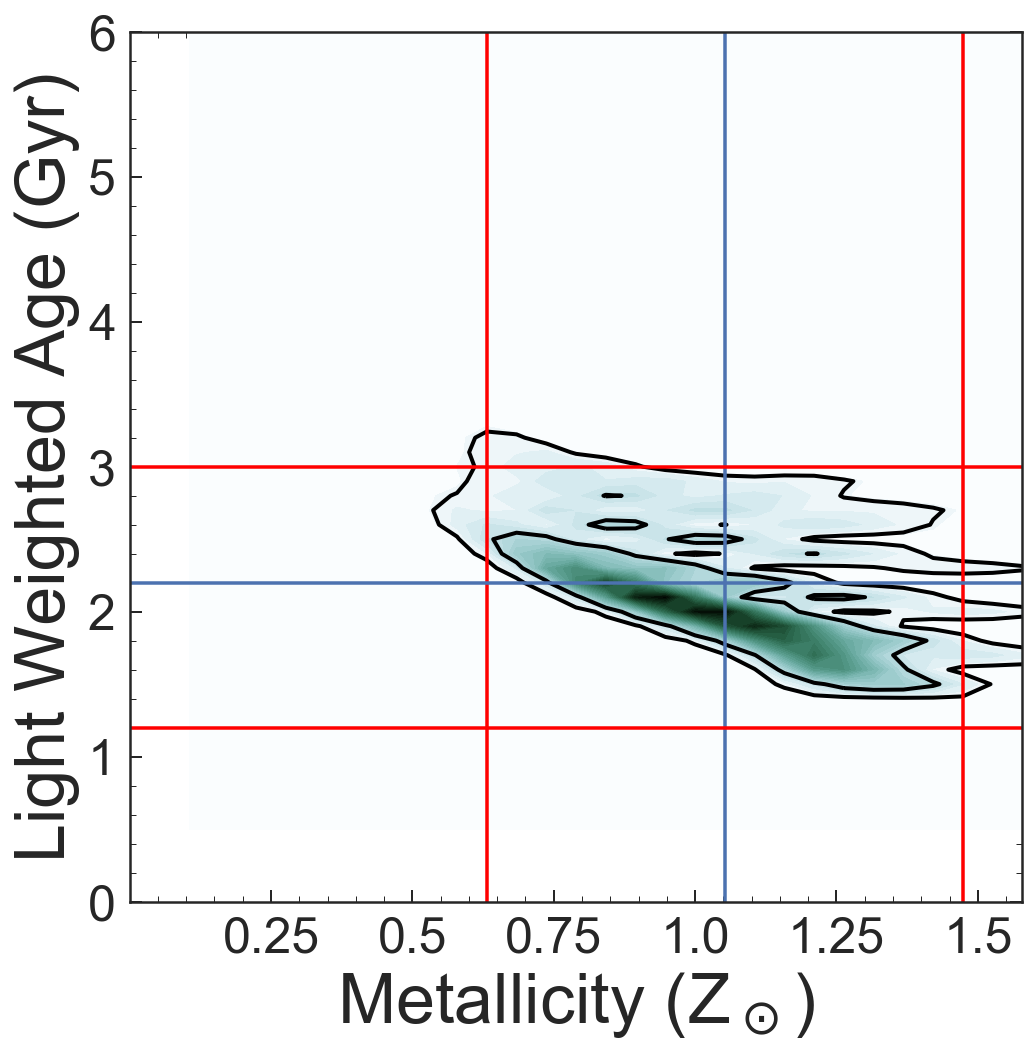

In [168]:
plt.figure(figsize=[8,8])
plt.contour(M,A,P,levels,colors='k',linewidths=2)
plt.contourf(M,A,P,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyr)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])
plt.axvline(0.02)
plt.axvline(0.012,color = 'r')
plt.axvline(0.028,color = 'r')

plt.axhline(2.2)
# plt.axhline(1.5,color = 'k')
# plt.axhline(3.5,color = 'k')
plt.axhline(1.2,color = 'r')
plt.axhline(3.,color = 'r')

In [205]:
chi = np.zeros(len(tau))

for i in range(len(tau)):
    spec.Sim_spec(0.02, 2.2, tau[i])
    chi[i] = np.sum(((spec.gal_fl - spec.fl) / spec.gal_er)**2)
    
ZP = np.exp(-chi/2).astype(np.float128) / np.trapz(np.exp(-chi/2).astype(np.float128),tau).astype(np.float128)

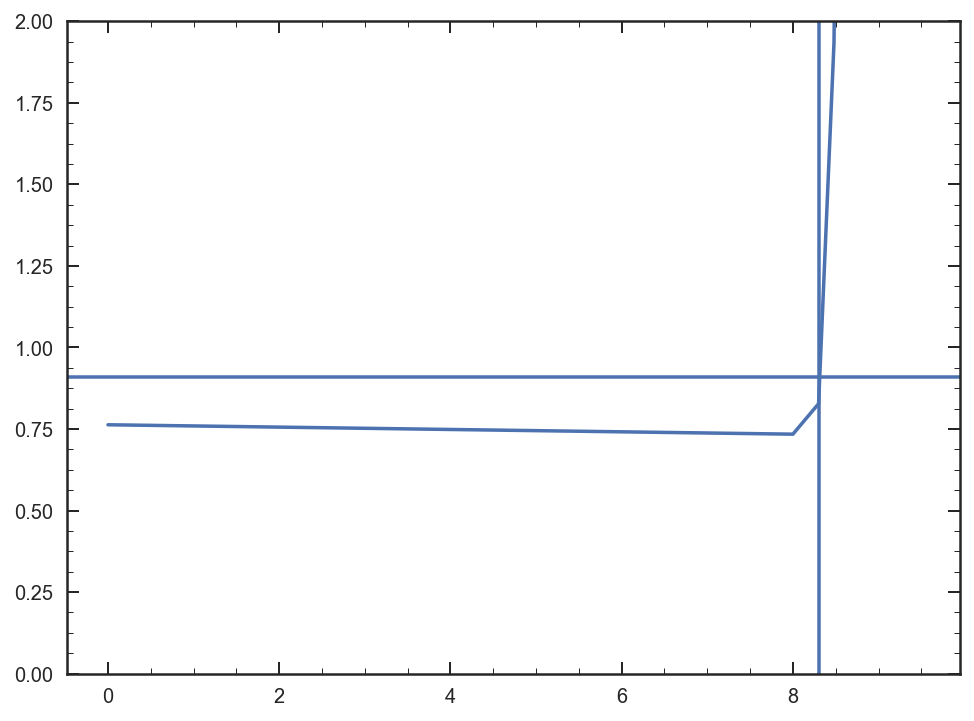

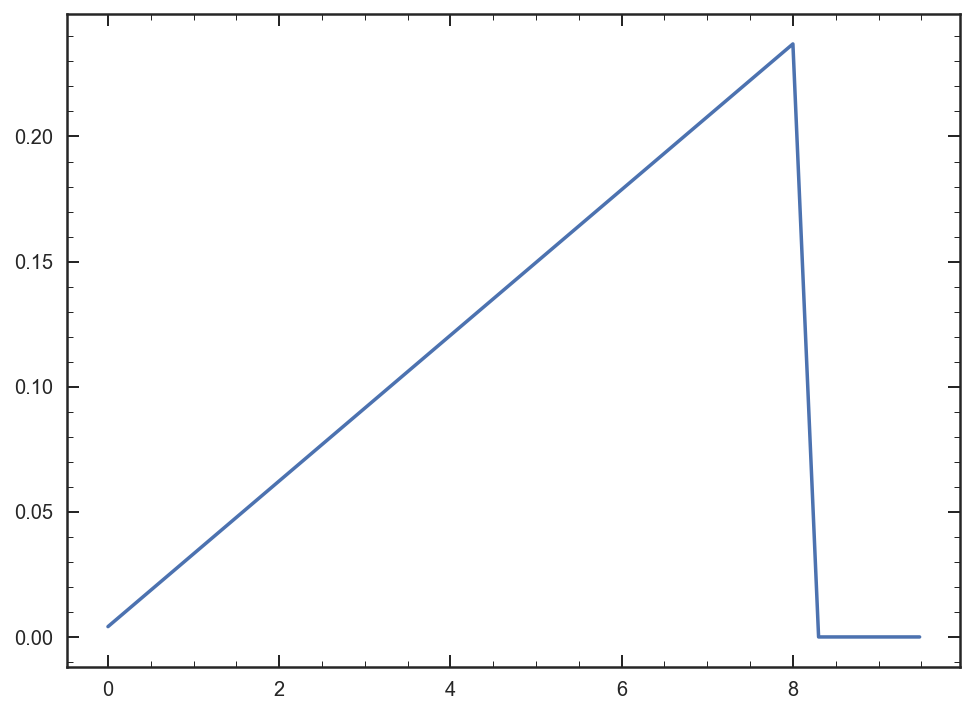

In [206]:
plt.figure(figsize=[8,6])
plt.plot(tau,chi/spec.gal_fl.size)
plt.ylim(0,2)
plt.axhline(.91)
plt.axvline(8.3)


plt.figure(figsize=[8,6])
plt.plot(tau,ZP)


In [207]:
print spec.gal_fl.size
print np.array(tau)[chi == chi.min()]
print chi[1] / spec.gal_fl.size
print chi.min()

281
[ 8.]
0.734082613191
206.277214307


In [196]:
tau[2]

8.3

In [167]:
.8*.19

0.15200000000000002

In [8]:
# (0.02, 0.012, 0.028)
# (2.2, 1.5, 3.0)

0.02
0.01
0.028
3.8
2.3
5.2


In [34]:
spec = Gen_spec(galDB['gids'][61], galDB['hi_res_specz'][61])
spec.Median_spec(0.02,2.2,tau)
print spec.bftau

../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
8.0


In [133]:
spec.Sim_spec(0.02,2.6, 8.3)
med_wv,med_fl = np.array([spec.gal_wv,spec.fl])

spec.Sim_spec(0.02,1.7, 8.0)
zl_wv,zl_fl = np.array([spec.gal_wv,spec.fl])

spec.Sim_spec(0.02,4.3, 8.7)
zh_wv,zh_fl = np.array([spec.gal_wv,spec.fl])

spec.Sim_spec(0.012, 2.6, 8.3)
tl_wv,tl_fl = np.array([spec.gal_wv,spec.fl])

spec.Sim_spec(0.028, 2.6, 8.3)
th_wv,th_fl = np.array([spec.gal_wv,spec.fl])


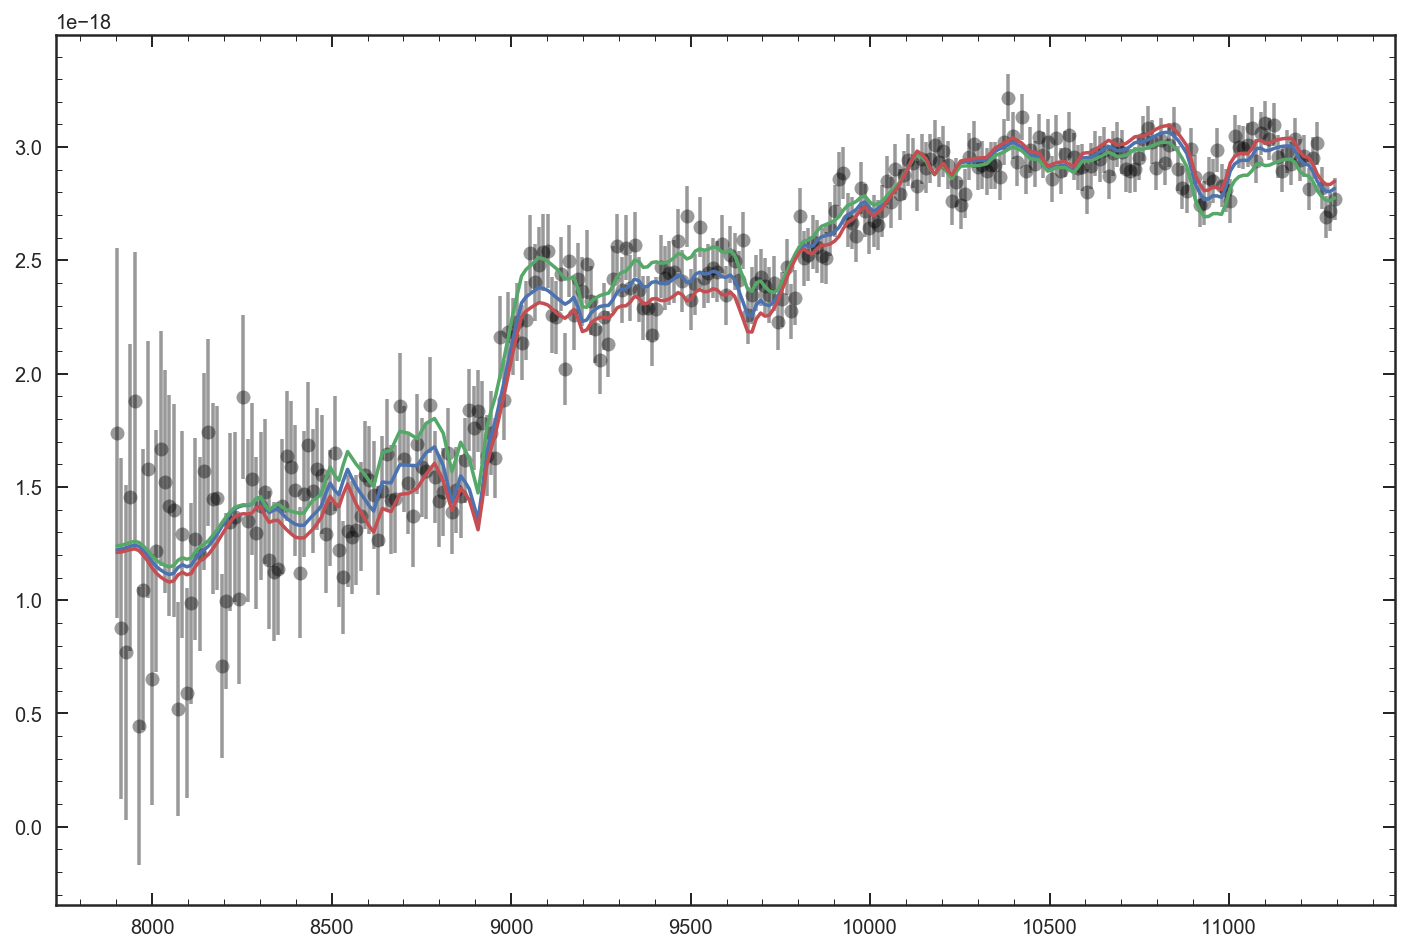

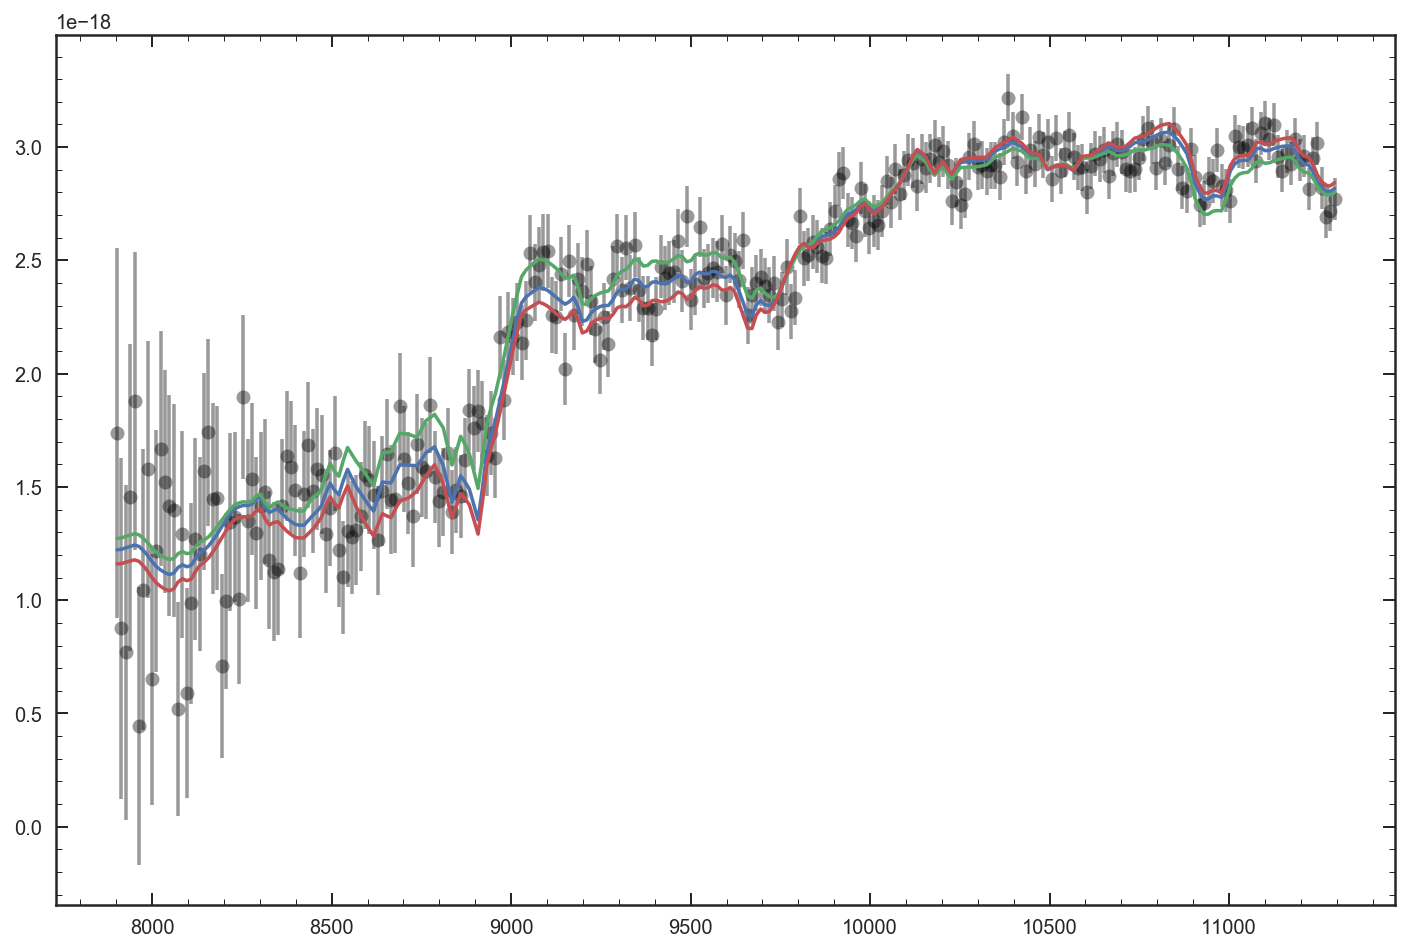

In [134]:
plt.figure(figsize=[12,8])
plt.errorbar(spec.gal_wv,spec.gal_fl,spec.gal_er,fmt='o',color = 'k', alpha = .4, zorder = 0)
plt.plot(med_wv,med_fl)
plt.plot(zl_wv,zl_fl)
plt.plot(zh_wv,zh_fl)

plt.figure(figsize=[12,8])
plt.errorbar(spec.gal_wv,spec.gal_fl,spec.gal_er,fmt='o',color = 'k', alpha = .4, zorder = 0)
plt.plot(med_wv,med_fl)
plt.plot(tl_wv,tl_fl)
plt.plot(th_wv,th_fl)

In [105]:
2 * np.sqrt(2/281.)

0.16872981624383912

In [ ]:
# [ 1.0526316  0.42105263  0.42105263]
# (2.2, 0.67500000000000000001, 0.802)

In [126]:
print 1.05 - 0.42,1.05 + 0.42
print 2.2 - 0.7,2.2 + 0.8

0.63 1.47
1.5 3.0


$\sigma = \sqrt{ 2 \nu}$ 

$\bar{\sigma} = \sqrt{ \frac{2}{\nu}}$


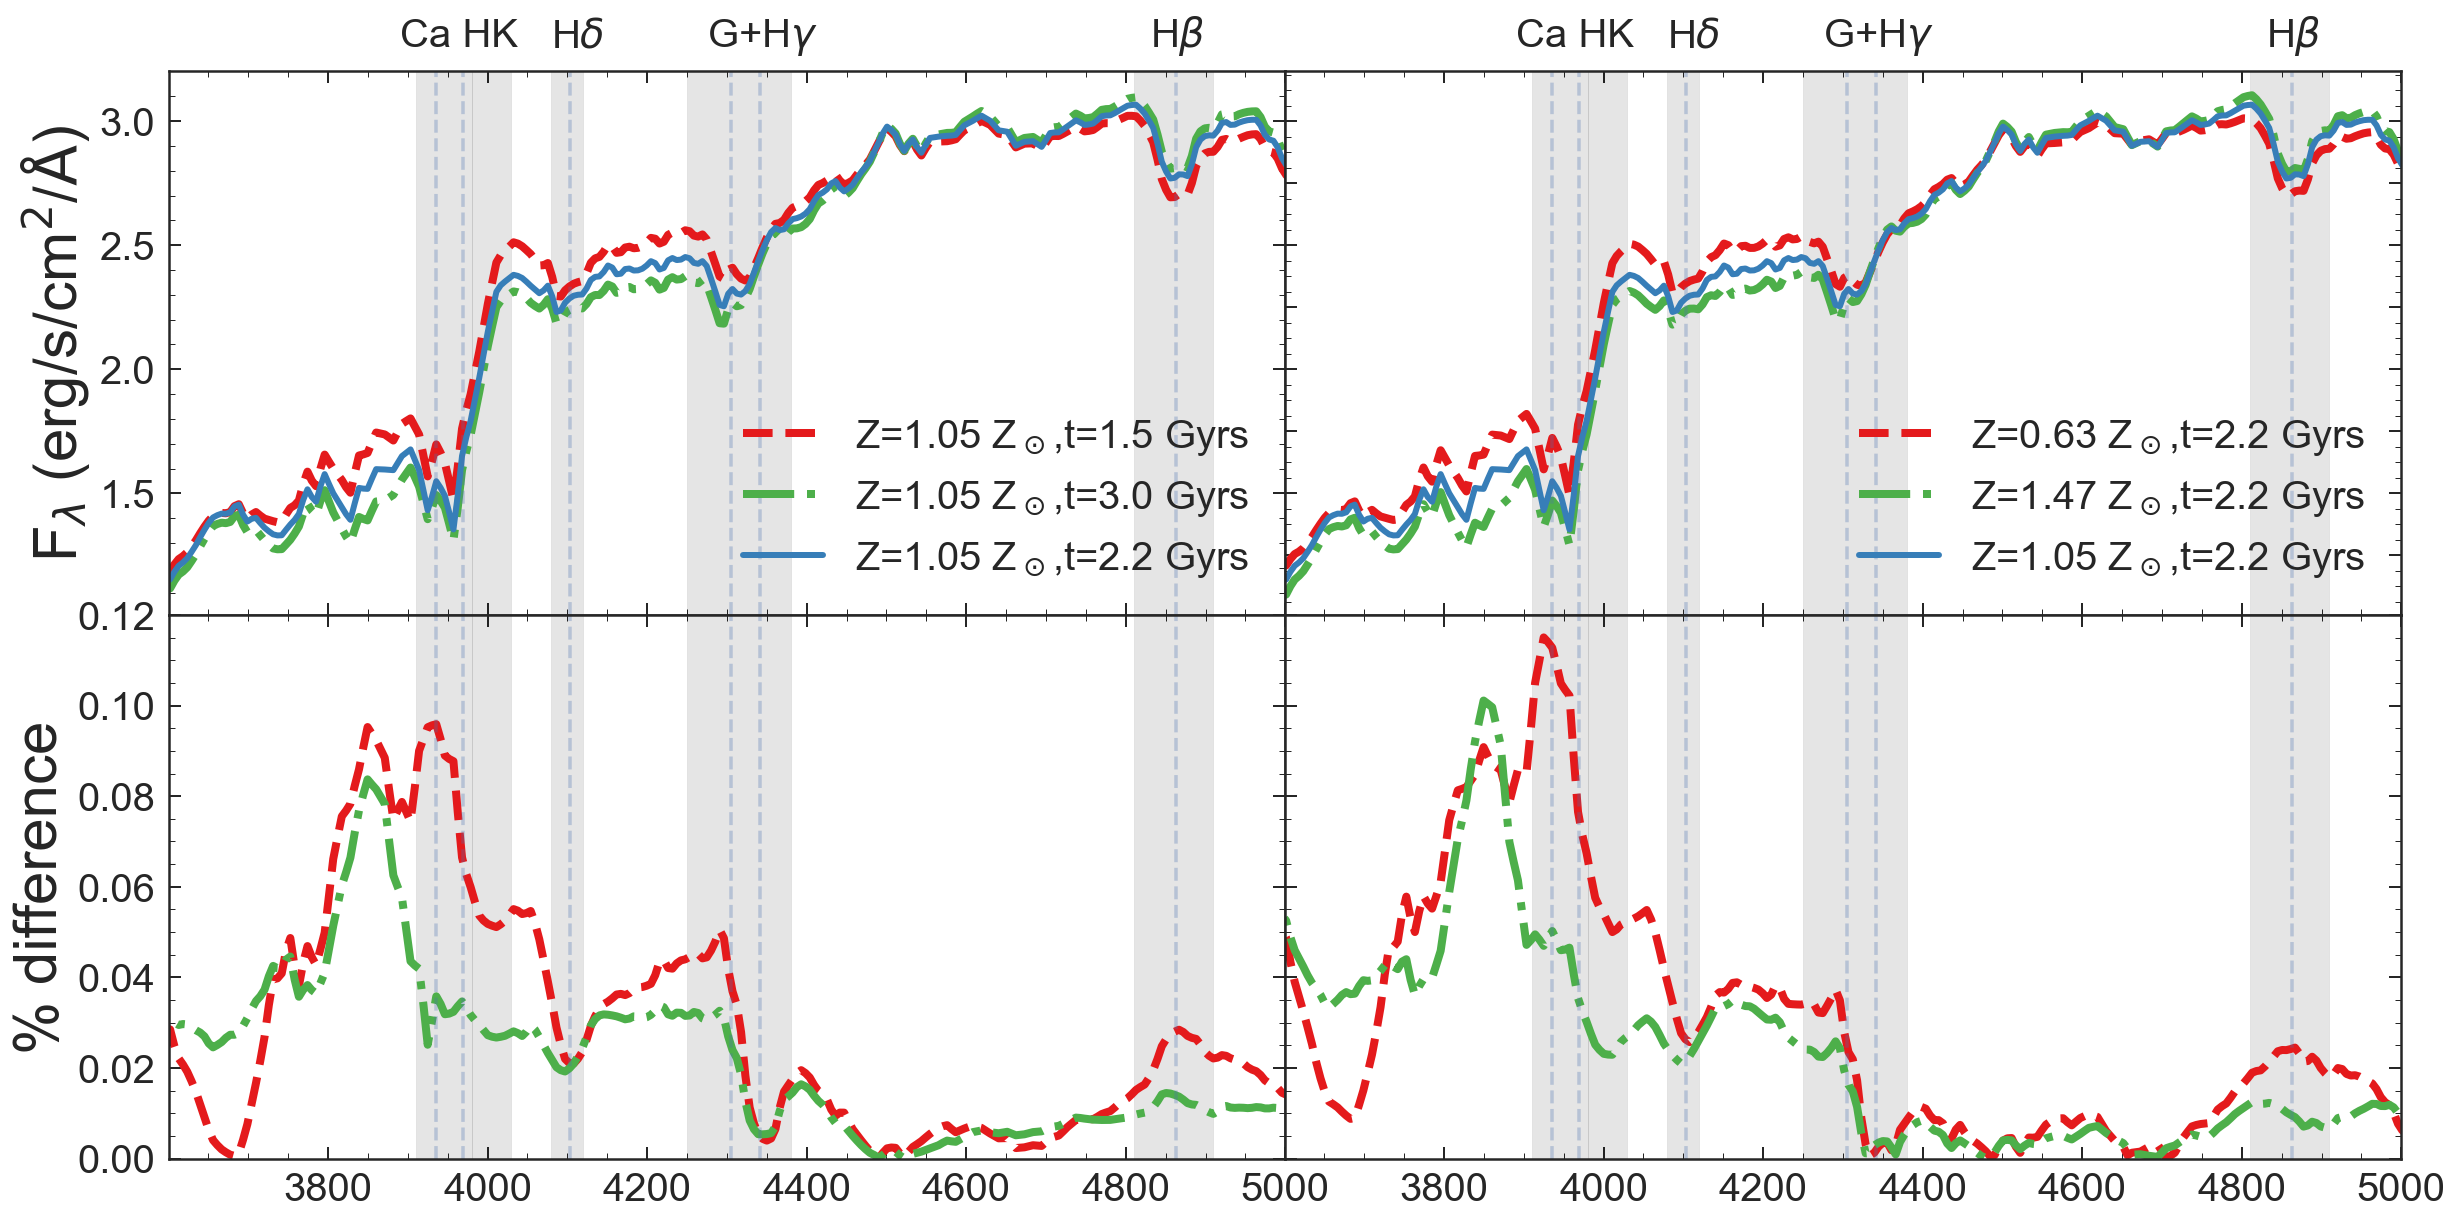

In [142]:
gs = gridspec.GridSpec(2,2,hspace=0,wspace=0)

plt.figure(figsize=[20,10])
plt.subplot(gs[0])
plt.plot(spec.gal_wv_rf, zl_fl *1E18,'--',color = '#e41a1c',linewidth = 4,label='Z={0} Z$_\odot$,t={1} Gyrs'.format(1.05,1.5))
plt.plot(spec.gal_wv_rf,zh_fl*1E18,'-.',color = '#4daf4a',linewidth = 4,label='Z={0} Z$_\odot$,t={1} Gyrs'.format(1.05,3.0))
plt.plot(spec.gal_wv_rf,med_fl*1E18,color = '#377eb8',linewidth = 3,label='Z={0} Z$_\odot$,t={1} Gyrs'.format(1.05,2.2))
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.text(3890,3.3,'Ca HK',fontsize=20)
plt.text(4080,3.3,'H$\delta$',fontsize=20)
plt.text(4275,3.3,'G+H$\gamma$',fontsize=20)
plt.text(4830,3.3,'H$\\beta$',fontsize=20)
plt.xlim(3601,5000)
plt.gca().tick_params(axis='x',labelbottom='off')
plt.ylim(1.01,3.2)
plt.ylabel('F$_\lambda$ (erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(gs[2])
plt.plot(spec.gal_wv_rf, np.abs(zl_fl- med_fl) / med_fl,'--',color = '#e41a1c',linewidth = 4)
plt.plot(spec.gal_wv_rf,np.abs(zh_fl- med_fl)/ med_fl,'-.',color = '#4daf4a',linewidth = 4)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.xlim(3601,5000)
plt.ylim(0,.12)
plt.ylabel('% difference',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(gs[1])
plt.plot(spec.gal_wv_rf, tl_fl*1E18,'--',color = '#e41a1c',linewidth = 4,label='Z={0} Z$_\odot$,t={1} Gyrs'.format(0.63,2.2))
plt.plot(spec.gal_wv_rf, th_fl*1E18,'-.',color = '#4daf4a',linewidth = 4,label='Z={0} Z$_\odot$,t={1} Gyrs'.format(1.47,2.2))
plt.plot(spec.gal_wv_rf,med_fl*1E18,color = '#377eb8',linewidth = 3,label='Z={0} Z$_\odot$,t={1} Gyrs'.format(1.05,2.2))
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.xlim(3601,5000)
plt.text(3890,3.3,'Ca HK',fontsize=20)
plt.text(4080,3.3,'H$\delta$',fontsize=20)
plt.text(4275,3.3,'G+H$\gamma$',fontsize=20)
plt.text(4830,3.3,'H$\\beta$',fontsize=20)
plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelleft='off')
plt.legend(fontsize=20)
plt.ylim(1.01,3.2)

plt.subplot(gs[3])
plt.plot(spec.gal_wv_rf, np.abs(tl_fl- med_fl)/ med_fl,'--',color = '#e41a1c',linewidth = 4)
plt.plot(spec.gal_wv_rf,np.abs(th_fl- med_fl)/ med_fl,'-.',color = '#4daf4a',linewidth = 4)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.gca().tick_params(axis='y',labelleft='off')
plt.ylim(0,.12)
plt.xlim(3601,5000)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('../plots/stack_param_shift.pdf',bbox_inches = 'tight')
